**Executed:** Tue Oct 11 12:24:31 2016

**Duration:** 613 seconds.

In [1]:
sigma = 0.016

time_window =  30
time_step   =  5
time_start  = -900
time_stop   =  900
decimation  =  20
t0_vary = True

true_params = dict(
    tau = 60,          # time constant
    init_value = 0.3,  # initial value (for t < t0) 
    final_value = 0.8, # final value   (for t -> +inf)
    t0 = 0)            # time origin

num_sim_cycles = 1000
taus = (30, 60)

In [2]:
# Cell inserted during automated execution.
time_start = -900
num_sim_cycles = 1000
t0_vary = False
time_window = 180
taus = (30, 60, 120, 240)
decimation = 20
time_stop = 900
time_step = 10
true_params = {'init_value': 0.3, 't0': 0, 'tau': 60, 'final_value': 0.8}
sigma = 0.053

### Notebook arguments

- **sigma** (*float*): standard deviation of additive Gaussian noise to be simulated
- **time_window** (*float*): seconds, integration window duration
- **time_step** (*float*): seconds, time step for the moving integration window
- **time_start** (*float*): seconds, start of time axis (kinetics starts at `t = t0`).
- **time_stop** (*float*): seconds, stop of time axis (kinetics starts at `t = t0`).
- **t0_vary** (*bool*): whether models should vary the curve origin (`t0`) during the fit
- **true_params** (*dict*): parameters used to generate simulated kinetic curves
- **num_sim_cycles** (*int*): number of times fit is repeated (Monte-Carlo)
- **taus** (*tuple*): list of values for time-costant `tau` simulated during repeated fits (Monte-Carlo).
----

# Simulated Kinetic Curve Fit

<p class=lead>This notebook fits simulated exponential transients with additive Gaissian noise in order to study time-constant fitting accuracy.
In particular we compare a simple exponential model with a more realistic model 
with integration window, checking the effect on the fit results.
<p>

You can either run this notebook directly, or run it through the [master notebook](Simulated Kinetic Curve Fit - Run-All.ipynb) for batch processing.

## Imports

In [3]:
%matplotlib inline
import numpy as np
import lmfit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import models  # custom module

numpy: 1.11.2
numba: 0.28.1
lmfit: 0.9.5


# Fitting models

Models used to fit the data.

## 1. Simple Exponential

In this model, we define the model function as an exponential transient:

$$ y = f(t) = A \cdot e^{-t/\tau} + K$$

The python function implementing it is:

- `models.exp_func()`.

Next cell defines and initializes the fitting model ([`lmfit.model.Model`](https://lmfit.github.io/lmfit-py/model.html#the-model-class)) including parameters' constrains:

In [5]:
labels = ('tau', 'init_value', 'final_value')
model = models.factory_model_exp(t0_vary=True)

## 2. Integrated Exponential

A more realistic model needs to take into account that each data point 
is the result of an **integration** over a **time window** $w$:

$$f(t) = A \cdot e^{-t/\tau} + K$$

$$y(t) = \int_{t}^{t+w} f(t')\;dt'$$

In other words, when we process a measurement in time chunks, we are integrating
a non-stationary signal $f(t)$ over a time window $w$. This integration causes
a smoothing of $f(t)$, regardless of the fact that time is binned or 
is swiped-through with a moving windows (overlapping chunks).

Numerically, $t$ is discretized with step equal to `(time_step / decimation)`.

The python function implementing this model function is:

- `models.expwindec_func()`.

And, finally, we define and initialize the fitting model parameters' constrains:

In [6]:
modelw = models.factory_model_expwin(t_window=time_window, decimation=decimation, t0_vary=t0_vary)

# Generative model

These are the models used to generate the simulates (noisy) data.

## 1. Simple Exponential + Noise

In this simple model, we simulate random data $Y$ as an exponential decay plus
additive Gaussian noise:

$$ Y(t_k) = f(t_k) + N_k $$

$$ \{N_k\} \sim {\rm Normal}\{\mu=0; \sigma\}$$

$$ \Delta t = t_k - t_{k-1} = \texttt{time_step}$$


## 2. Integrated Exponential + Noise

For the "integrating window" model, we first define a finer time axis $\theta_i$ 
which oversamples $t_k$ by a factor $n$. Then we define the function $Y_f$ 
adding Gaussian noise $\sqrt{n}\,N_i$, with $n$ times larger variance:

$$ Y_f(\theta_i) = f(\theta_i) + \sqrt{n}\,N_i $$

$$ \Delta \theta = \theta_i - \theta_{i-1} = \texttt{time_step} \;/\; n$$

Finally, by averaging each time window, we compute the data on the coarse time axis $t_k$:

$$ Y_w(t_k) = \frac{1}{m}\sum_{i} Y_f(\theta_i)$$

Here, for each $t_k$, we compute the mean of $m$ consecutive $Y_f$ values. The number $m$ 
is chosen so that $m\, \Delta \theta$ is equal to the time window.


## Noise amplitude

The amplitude of the additive noise ($\sigma$) is estimated from the experimental kinetic curves.
In particular we take the variance from the **POST** period (i.e. the steady state period after the transient).
The **POST** period has been chosen because it exhibits higher variance than the **PRE** period (i.e. the steady state period
before the transient). These values have been calculated in [8-spot bubble-bubble kinetics - Summary](8-spot bubble-bubble kinetics - Summary.ipynb).

In both models we define the **noise amplitude** as `sigma` (see first cell):

    sigma = 0.016


## Time axis

We also define the parameters for the time axis $t$:

    time_start = -900    # seconds 
    time_stop  =  900    # seconds
    time_step  = 5       # seconds
    

## Kinetic curve paramenters

The simulated kinetic curve has the following parameters:

    true_params = dict(
        tau = 60,          # time constant
        init_value = 0.3,  # initial value (for t < t0) 
        final_value = 0.8, # final value   (for t -> +inf)
        t0 = 0)            # time origin


<div class="alert alert-info">
**NOTE**: All previous parameters are defined in the first notebook cell. 
</div>

# Single kinetic curve fit

Here we simulate one kinetic curve and **fit** it with the two models ([simple exponential](#1.-Simple-Exponential) and [integrated exponential](#2.-Integrated-Exponential)).

## Draw simulated data

Time axis for simulated data:

In [7]:
t = np.arange(time_start, time_stop-time_window, time_step).astype(float)
t.size

162

An ideal transient (no noise, no integration):

In [8]:
y = models.expwindec_func(t, t_window=time_window, **true_params)
y.shape

(162,)

A simulated transient (including noise + integration):

In [9]:
time_window, time_step

(180, 10)

In [10]:
yr = models.expwindec_func(t, t_window=time_window, sigma=sigma, **true_params)
yr.shape

(162,)

Plot the computed curves:

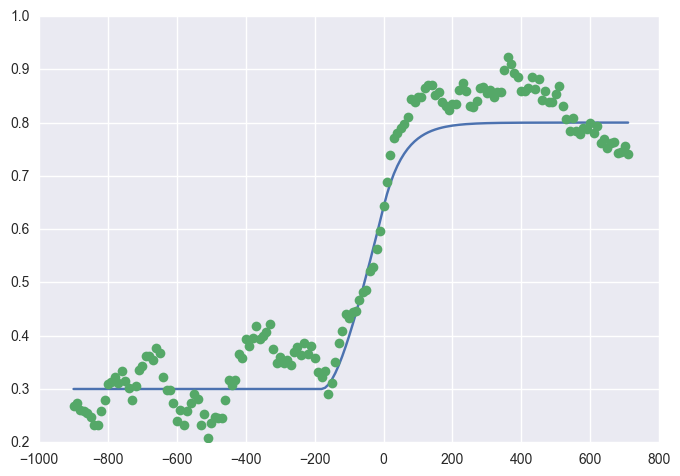

In [11]:
plt.plot(t, y, '-', label='model')
plt.plot(t, yr, 'o', label='model + noise')

## Fit data

Fit the "Integrated Exponential" model:

In [12]:
#%%timeit
resw = modelw.fit(yr, t=t, tau=10, init_value=0.1, final_value=0.9, verbose=False)

Fit the "Simple Exponential" model:

In [13]:
#%%timeit
res = model.fit(yr, t=t + 0.5*time_window, tau=10, init_value=0.1, final_value=0.9, verbose=False)

Print and plot fit results:

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/lmfit/confidence.py:295: UserWarning: Warning, rel_change=-0.015163388069623607 < 0.01  at iteration 10 and prob(t0=-11.135590857214812) = 0.7136347319096124 < max(sigmas).
  warn(errmsg)
/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/lmfit/confidence.py:295: UserWarning: Warning, rel_change=-0.15167298442814434 < 0.01  at iteration 6 and prob(t0=0.7423727238143214) = 0.46783104805686504 < max(sigmas).
  warn(errmsg)


[[Fit Statistics]]
    # function evals   = 98
    # data points      = 162
    # variables        = 4
    chi-square         = 0.454
    reduced chi-square = 0.003
    Akaike info crit   = -944.098
    Bayesian info crit = -931.747
[[Variables]]
    t0:           -3.71186361 +/- 5.723950 (154.21%) (init= 0)
    tau:           75.6330342 +/- 9.097793 (12.03%) (init= 10)
    init_value:    0.32173131 +/- 0.005956 (1.85%) (init= 0.1)
    final_value:   0.83765179 +/- 0.007528 (0.90%) (init= 0.9)
[[Correlations]] (unreported correlations are <  0.100)
    C(t0, tau)                   = -0.683 
    C(tau, final_value)          =  0.480 
    C(t0, final_value)           = -0.183 
    C(t0, init_value)            =  0.153 
                99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 t0         :      -inf      -inf  -9.20720  -3.71186       inf       inf       inf
 tau        :  46.36150  52.80579  62.41220  75.63303  82.95137  95.24545 111.22354
 init_value :   0.3037

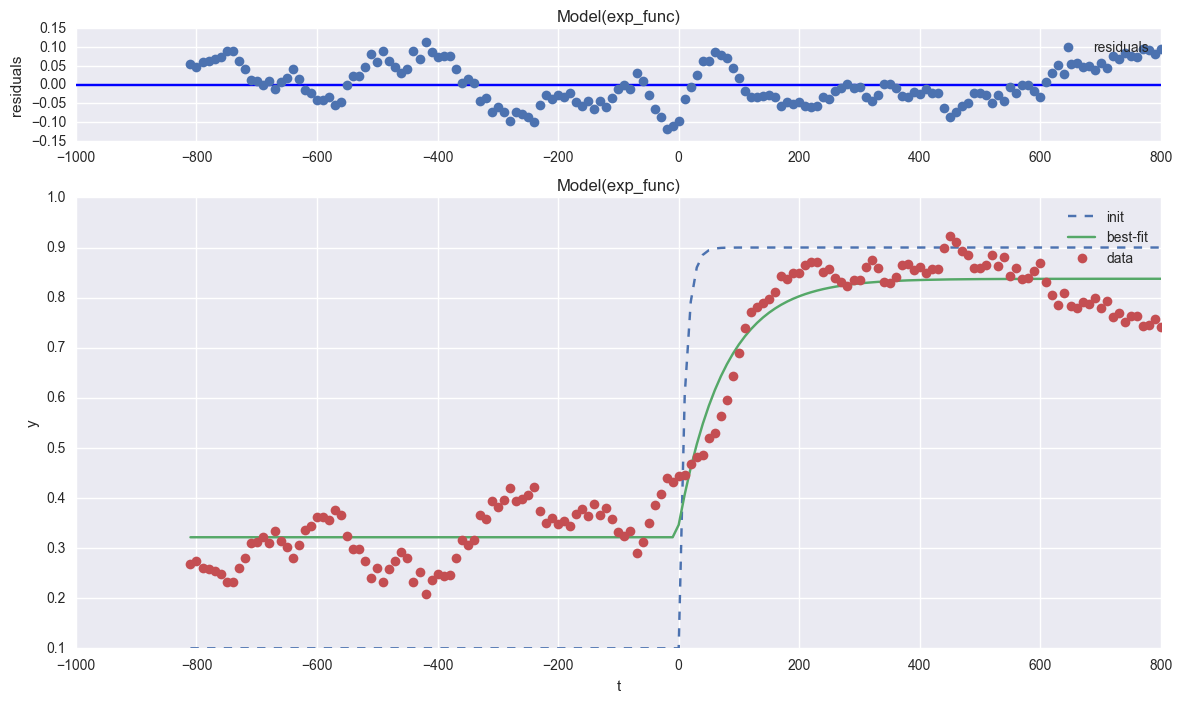

In [14]:
fig = plt.figure(figsize=(14, 8))
res.plot(fig=fig)
ci = lmfit.conf_interval(res, res)
lmfit.report_fit(res)
print(lmfit.ci_report(ci, with_offset=False))
#plt.xlim(-300, 300)

[[Fit Statistics]]
    # function evals   = 35
    # data points      = 162
    # variables        = 3
    chi-square         = 0.383
    reduced chi-square = 0.002
    Akaike info crit   = -973.863
    Bayesian info crit = -964.600
[[Variables]]
    t0:            0 (fixed)
    t_window:      180 (fixed)
    tau:           57.6303939 +/- 6.112462 (10.61%) (init= 10)
    init_value:    0.31516042 +/- 0.005497 (1.74%) (init= 0.1)
    final_value:   0.83566539 +/- 0.006581 (0.79%) (init= 0.9)
    sigma:         0 (fixed)
    decimation:    20 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(tau, final_value)          =  0.457 
    C(tau, init_value)           =  0.195 
                99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 tau        :  42.08312  47.29362  52.39599  57.63039  63.03200  68.65168  74.78008
 init_value :   0.29865   0.30435   0.30977   0.31516   0.32055   0.32597   0.33165
 final_value:   0.81644   0.82304   0.82934   0.8356

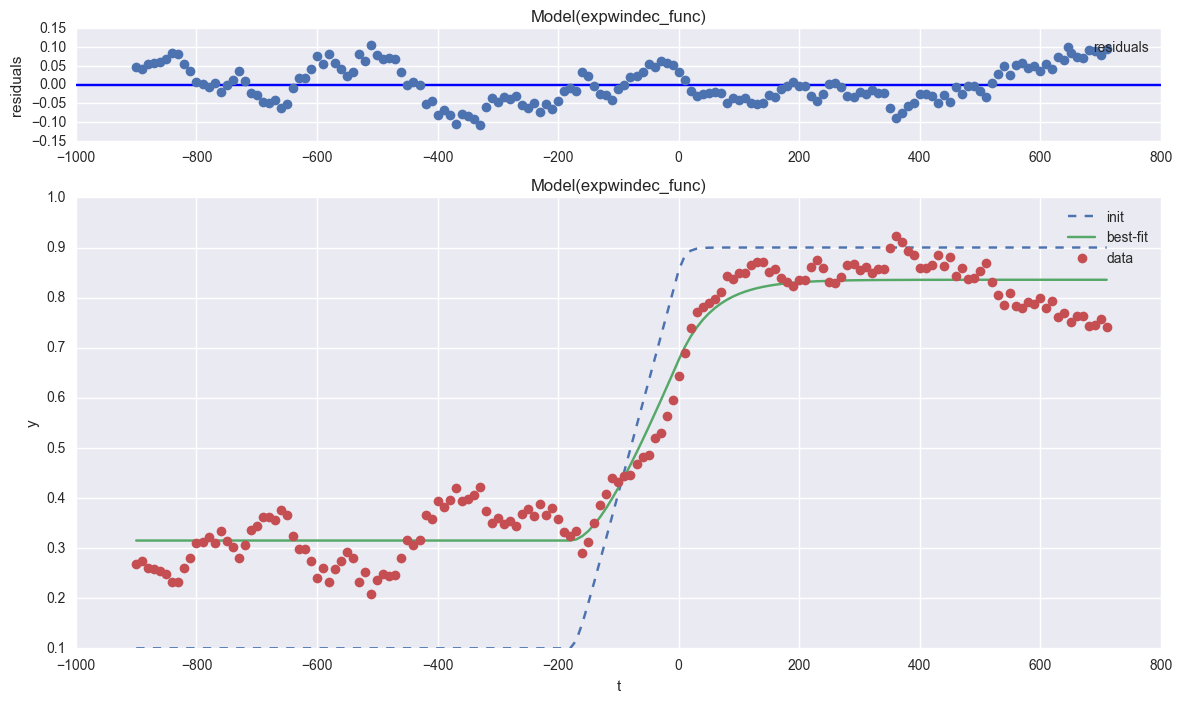

In [15]:
fig = plt.figure(figsize=(14, 8))
resw.plot(fig=fig)
ci = lmfit.conf_interval(resw, resw)
lmfit.report_fit(resw)
print(lmfit.ci_report(ci, with_offset=False))
#plt.xlim(-300, 300)

# Monte-Carlo Simulation

Here, fixed the model paramenters, we generate and fit several noisy datasets. Then, by plotting the distribution of the fitted parameters, we assess the stability and accuracy of the fit.

## Parameters

The number simulation cycles is defined by `num_sim_cycles`. Current value is:

In [16]:
num_sim_cycles

1000

The **fixed** kinetic curve parameters are:

In [17]:
{k: v for k, v in true_params.items() if k is not "tau"}

{'final_value': 0.8, 'init_value': 0.3, 't0': 0}

While `tau` is varied, taking the following values:

In [18]:
taus

(30, 60, 120, 240)

In [19]:
t0_vary

False

<div class="alert alert-info">
**NOTE**: All previous parameters are defined in the first notebook cell. 
</div>

## Functions

Here we define two functions:

- `draw_samples_and_fit()` draws a set of data and fits it with **both** models

- `monte_carlo_sim()` run the Monte-Carlo simulation: calls `draw_samples_and_fit()` many times.

> **NOTE:** Global variables are used by previous functions.

In [20]:
def draw_samples_and_fit(true_params):
    # Create the data
    t = np.arange(time_start, time_stop-time_window, time_step).astype(float)
    yr = models.expwindec_func(t, t_window=time_window, sigma=sigma, decimation=100, **true_params)

    # Fit the model
    tc = t + 0.5*time_window
    kws = dict(fit_kws=dict(nan_policy='omit'), verbose=False)
    res = model.fit(yr, t=tc, tau=90, method='nelder', **kws)
    res = model.fit(yr, t=tc, **kws)
    resw = modelw.fit(yr, t=t, tau=400, decimation=decimation, method='nelder', **kws)
    resw = modelw.fit(yr, t=t, decimation=decimation, **kws)
    return res, resw

In [21]:
def monte_carlo_sim(true_params, N):
    df1 = pd.DataFrame(index=range(N), columns=labels)
    df2 = df1.copy()
    for i in range(N):
        res1, res2 = draw_samples_and_fit(true_params)
        for var in labels:
            df1.loc[i, var] = res1.values[var]
            df2.loc[i, var] = res2.values[var]
    return df1, df2

## Run Monte-Carlo simulation

Run the Monte-Carlo fit for a set of different time-constants (`taus`)
and save results in two `DataFrames`, one for each model.

In [22]:
mc_results1, mc_results2 = [], []

In [23]:
%%timeit -n1 -r1   # <-- prints execution time
for tau in taus:
    true_params['tau'] = tau
    df1, df2 = monte_carlo_sim(true_params, num_sim_cycles)
    mc_results1.append(df1)
    mc_results2.append(df2)

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/lmfit/minimizer.py:427: RuntimeWarning: overflow encountered in multiply
  r = (r*r).sum()


/Users/anto/Google Drive/notebooks/multispot_paper/realtime kinetics/models.py:21: RuntimeWarning: overflow encountered in exp
  y[m] = A * (1 - np.exp(-(t[m] - t0)/tau)) + init_value


1 loop, best of 1: 9min 50s per loop


<div class="alert alert-danger">
**WARNING**: The previous cell can take a long to execute. Execution time scales with **`num_sim_cycles * len(taus)`**. 
</div>

## Results1 - Simple Exponential

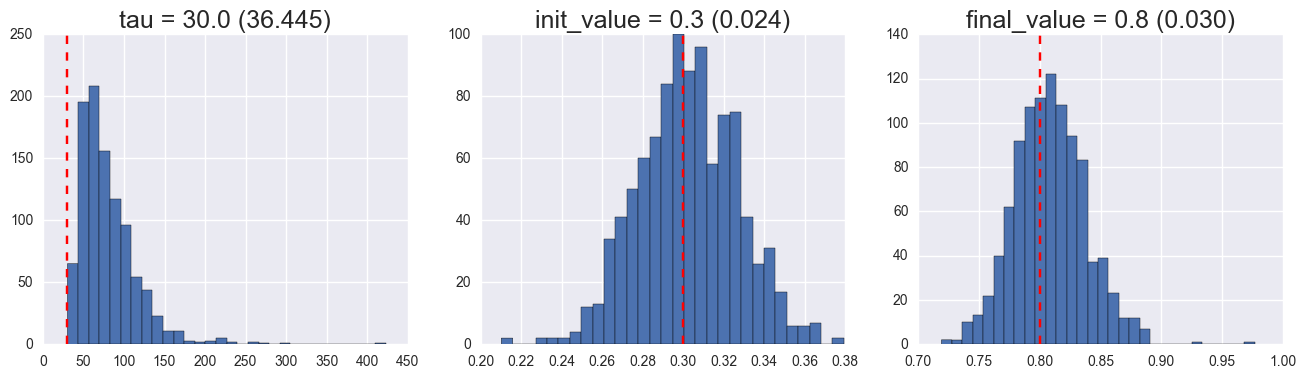

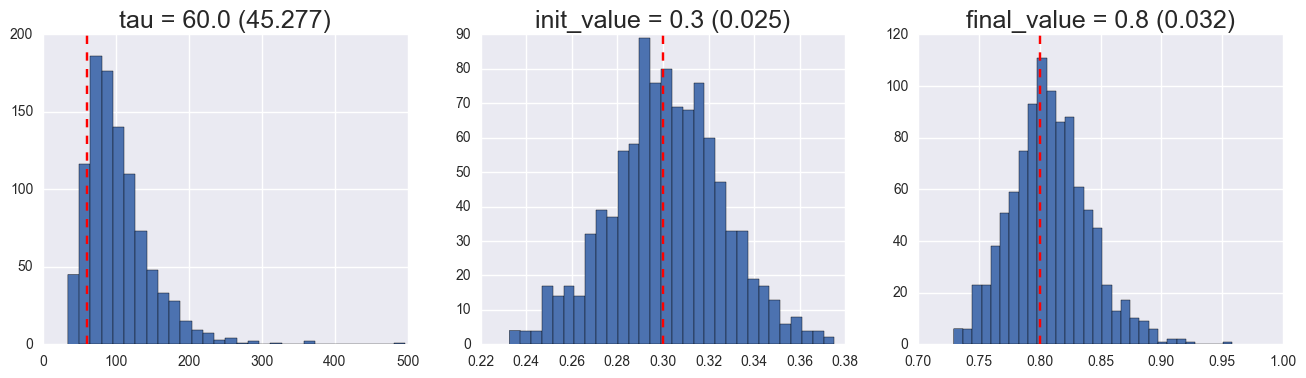

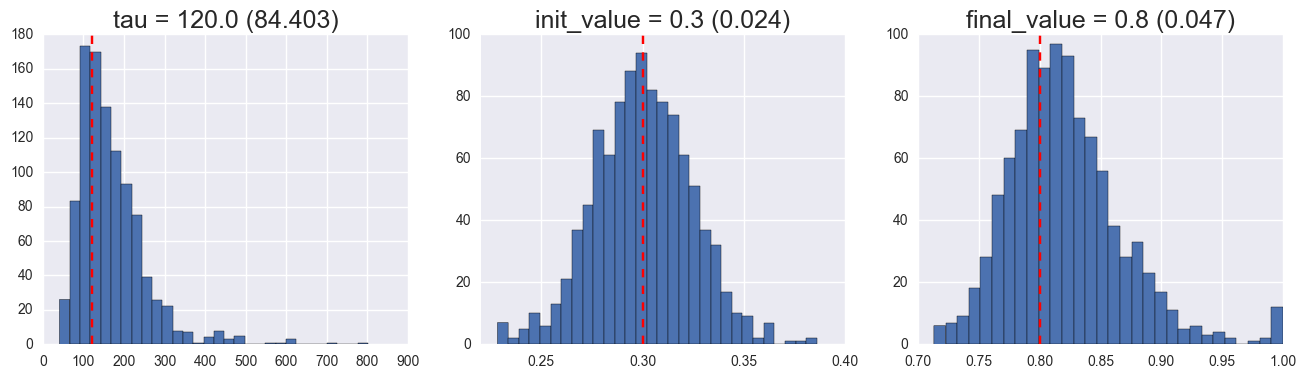

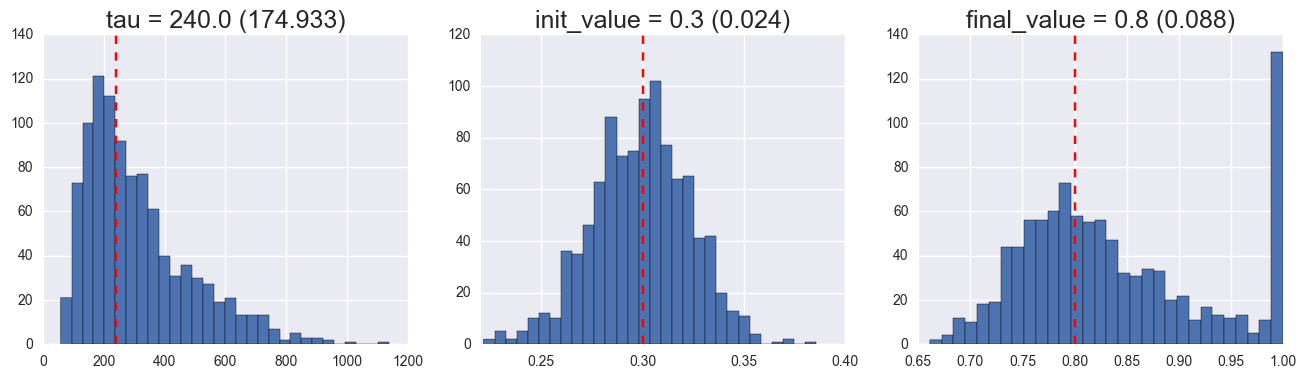

In [24]:
for tau, df in zip(taus, mc_results1):
    true_params['tau'] = tau
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    for i, var in enumerate(labels):
        std = df[var].std()
        df[var].hist(bins=30, ax=ax[i])
        ax[i].set_title("%s = %.1f (%.3f)" % (var, true_params[var], std), fontsize=18)
        ax[i].axvline(true_params[var], color='r', ls='--')
    #print('True parameters: %s' % true_params)

## Results2 - Integrated Exponential

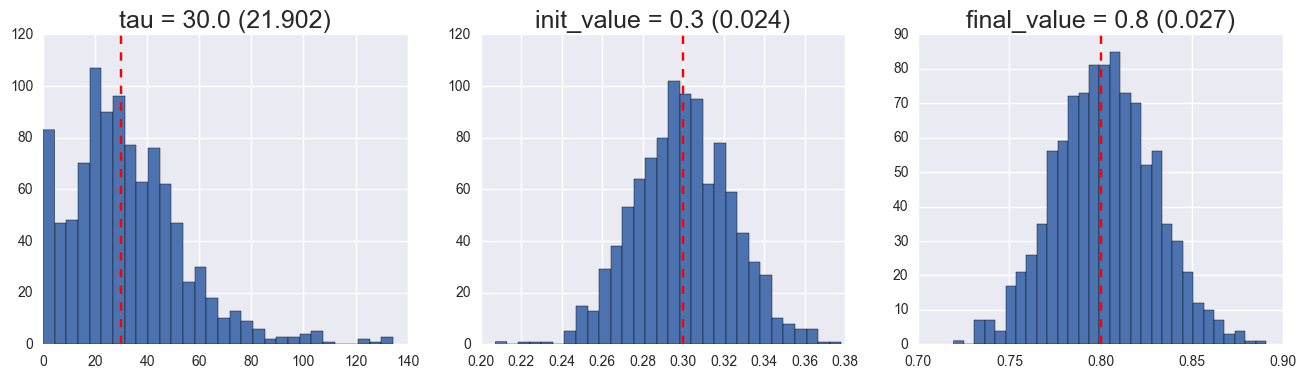

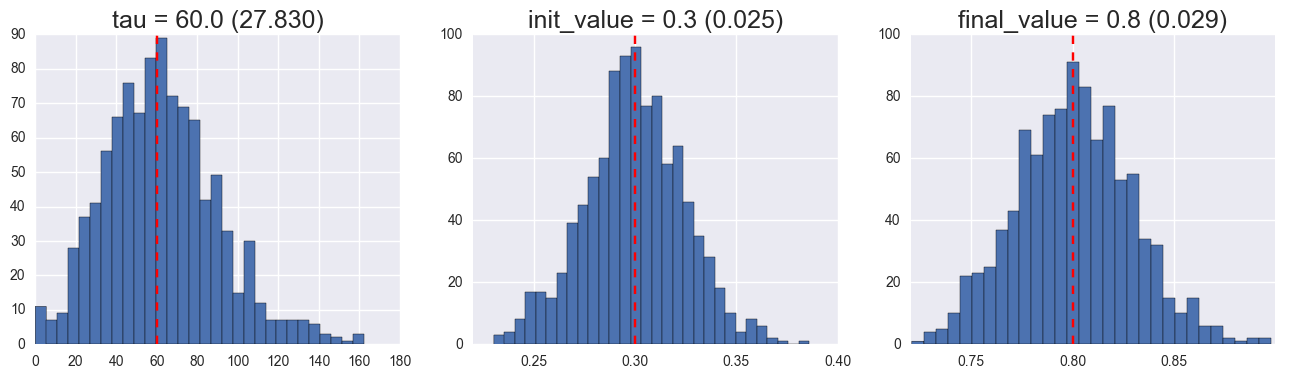

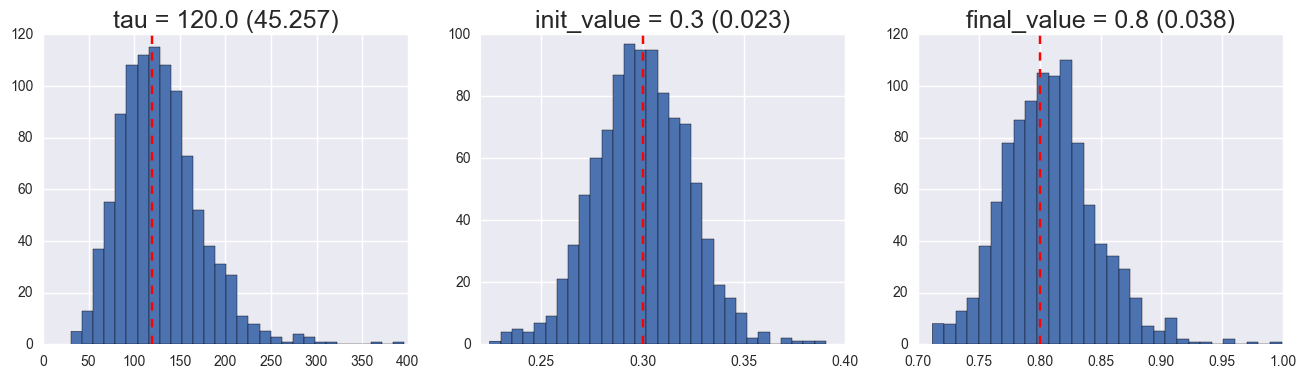

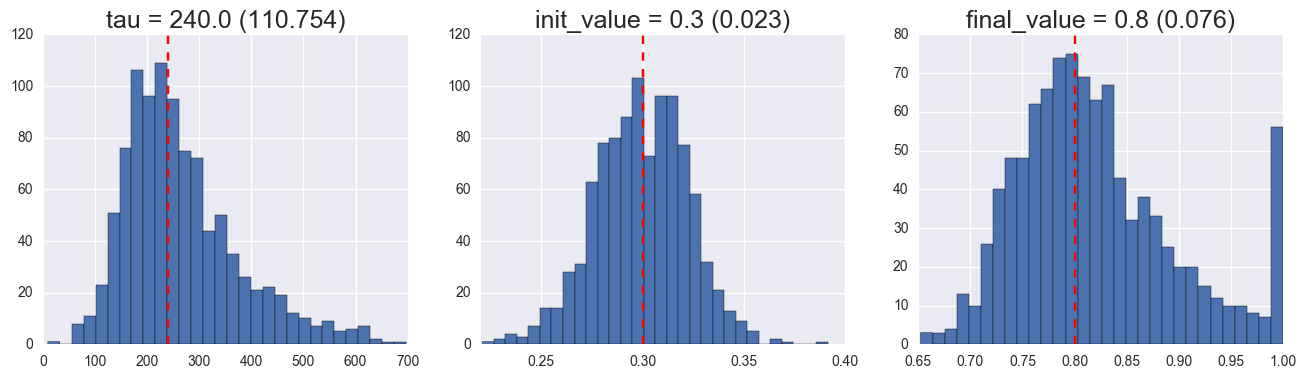

In [25]:
for tau, df in zip(taus, mc_results2):
    true_params['tau'] = tau
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    for i, var in enumerate(labels):
        std = df[var].std()
        df[var].hist(bins=30, ax=ax[i])
        ax[i].set_title("%s = %.1f (%.3f)" % (var, true_params[var], std), fontsize=18)
        ax[i].axvline(true_params[var], color='r', ls='--')
    #print('True parameters: %s' % true_params)

# Conclusions

The last two multipanel figures compare the fitting accuracy
of the model parameter for the **simple-exponential** and **integrated-exponential** models.
We note that, in particular for the `tau` parameter, 
the **integrated exponential** model is significantly more accurate,
providing good estimates at much smaller integration times.

This comparison demonstrates empirically the strong advantage 
in using the theoretically more correct
**integrated exponential** model.
